In [10]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import keras

In [11]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm


In [12]:
from tensorflow.keras.metrics import MeanIoU

In [13]:
from PIL import Image
from PIL import ImageEnhance

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

In [15]:
from patchify import patchify

In [16]:
import os

root_directory = os.path.join(os.getcwd(), "dataset")  # Get the full path
print("Dataset path:", root_directory)

if os.path.exists(root_directory):
    print("Dataset directory found!")
else:
    print("Dataset directory NOT found!")


Dataset path: /Users/srinivasadesikan/SURYA_AD4/dataset
Dataset directory found!


In [17]:
patch_size = 512

In [18]:
image_dataset = []
for path, subdirs, files in os.walk(root_directory):
    #print(path)
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):
            if image_name.endswith(".png"):   #Only read png images...

                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner

                img_enhancer = ImageEnhance.Brightness(image)
                factor = 1.5
                enhanced_output = img_enhancer.enhance(factor)
                image = enhanced_output

                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)

                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name, len(image_dataset))
                if image.shape[0] < patch_size or image.shape[1] < patch_size:
                    print(f"Skipping {image_name}: Image too small for patch size {patch_size}")
                    continue

                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):

                        single_patch_img = patches_img[i,j,:,:]

                        #Use minmaxscaler instead of just dividing by 255.
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

                        #single_patch_img = (single_patch_img.astype('float32')) / 255.
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.
                        image_dataset.append(single_patch_img)

Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images/0.png 0
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images/1.png 6
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images/10.png 21
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images/100.png 24
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images/101.png 36
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images/102.png 51
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images/103.png 66
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images/104.png 81
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images/105.png 96
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images/106.png 111
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images/11.png 126
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images/12.png 129
Now patchi

In [19]:
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    #print(path)
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)

                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)

                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name, len(mask_dataset))
                if mask.shape[0] < patch_size or mask.shape[1] < patch_size:
                    print(f"Skipping {mask_name}: Mask too small for patch size {patch_size}")
                    continue

                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):

                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.
                        mask_dataset.append(single_patch_mask)

Now patchifying mask: /Users/srinivasadesikan/SURYA_AD4/dataset/discards/masks/38.png 0
Skipping 38.png: Mask too small for patch size 512
Now patchifying mask: /Users/srinivasadesikan/SURYA_AD4/dataset/discards/masks/54.png 0
Skipping 54.png: Mask too small for patch size 512
Now patchifying mask: /Users/srinivasadesikan/SURYA_AD4/dataset/discards/masks/57.png 0
Skipping 57.png: Mask too small for patch size 512
Now patchifying mask: /Users/srinivasadesikan/SURYA_AD4/dataset/discards/masks/60.png 0
Skipping 60.png: Mask too small for patch size 512
Now patchifying mask: /Users/srinivasadesikan/SURYA_AD4/dataset/discards/masks/62.png 0
Skipping 62.png: Mask too small for patch size 512
Now patchifying mask: /Users/srinivasadesikan/SURYA_AD4/dataset/discards/masks/67.png 0
Skipping 67.png: Mask too small for patch size 512
Now patchifying mask: /Users/srinivasadesikan/SURYA_AD4/dataset/discards/masks/69.png 0
Skipping 69.png: Mask too small for patch size 512
Now patchifying mask: /User

In [20]:
image_dataset = []
mask_dataset = []

image_dir = "/Users/srinivasadesikan/SURYA_AD4/dataset/images"
mask_dir = "/Users/srinivasadesikan/SURYA_AD4/dataset/masks"

image_files = sorted(os.listdir(image_dir))

for img_file in image_files:
    if not img_file.endswith(".png"):
        continue

    img_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(mask_dir, img_file)

    if not os.path.exists(mask_path):
        print(f"Skipping {img_file}: No corresponding mask")
        continue

    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    h, w = image.shape[:2]
    new_h = (h // patch_size) * patch_size
    new_w = (w // patch_size) * patch_size

    if new_h < patch_size or new_w < patch_size:
        print(f"Skipping {img_file}: Too small for patch size {patch_size}")
        continue

    image = Image.fromarray(image).crop((0, 0, new_w, new_h))
    mask = Image.fromarray(mask).crop((0, 0, new_w, new_h))

    image = np.array(image)
    mask = np.array(mask)

    patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
    patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            img_patch = patches_img[i, j, 0]
            mask_patch = patches_mask[i, j, 0]

            # Normalize the image patch
            img_patch = scaler.fit_transform(img_patch.reshape(-1, 3)).reshape(img_patch.shape)

            image_dataset.append(img_patch)
            mask_dataset.append(mask_patch)


In [21]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

In [74]:
scaler = MinMaxScaler()
image_dataset = []
mask_dataset = []

for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]

    if dirname == 'images':
        image_path = path
        mask_path = path.replace('images', 'masks')  # assumes parallel directory structure

        images = sorted(os.listdir(image_path))
        masks = sorted(os.listdir(mask_path))

        for img_name, mask_name in zip(images, masks):
            if img_name.endswith('.png') and mask_name.endswith('.png'):
                image = cv2.imread(os.path.join(image_path, img_name))
                mask = cv2.imread(os.path.join(mask_path, mask_name))
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

                SIZE_X = (image.shape[1] // patch_size) * patch_size
                SIZE_Y = (image.shape[0] // patch_size) * patch_size

                image = Image.fromarray(image).crop((0, 0, SIZE_X, SIZE_Y))
                mask = Image.fromarray(mask).crop((0, 0, SIZE_X, SIZE_Y))

                image = np.array(image)
                mask = np.array(mask)

                if image.shape[0] < patch_size or image.shape[1] < patch_size:
                    print(f"Skipping {img_name}: Image too small")
                    continue

                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        img_patch = patches_img[i, j, 0]
                        mask_patch = patches_mask[i, j, 0]

                        # Normalize image patch
                        img_patch = scaler.fit_transform(img_patch.reshape(-1, 3)).reshape(img_patch.shape)

                        image_dataset.append(img_patch)
                        mask_dataset.append(mask_patch)

image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)



Skipping 38.png: Image too small
Skipping 54.png: Image too small
Skipping 57.png: Image too small
Skipping 60.png: Image too small
Skipping 62.png: Image too small
Skipping 67.png: Image too small
Skipping 69.png: Image too small
Skipping 73.png: Image too small
Skipping 75.png: Image too small
Skipping 93.png: Image too small
Skipping 94.png: Image too small


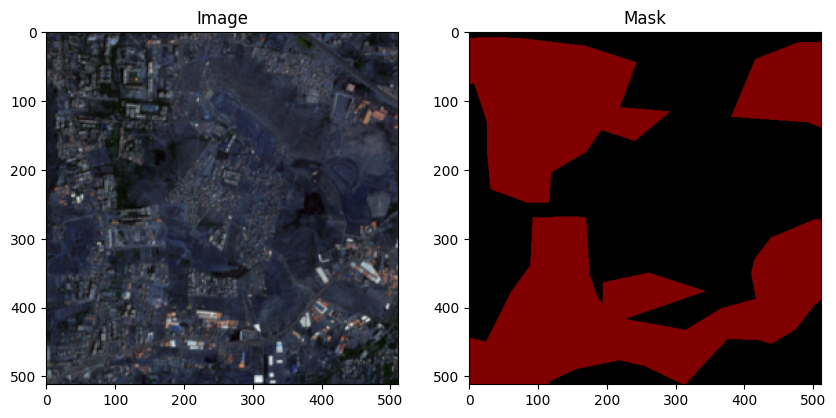

In [142]:
import random 
index = random.randint(0, len(image_dataset) - 1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(image_dataset[index])
plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask_dataset[index])
plt.show()


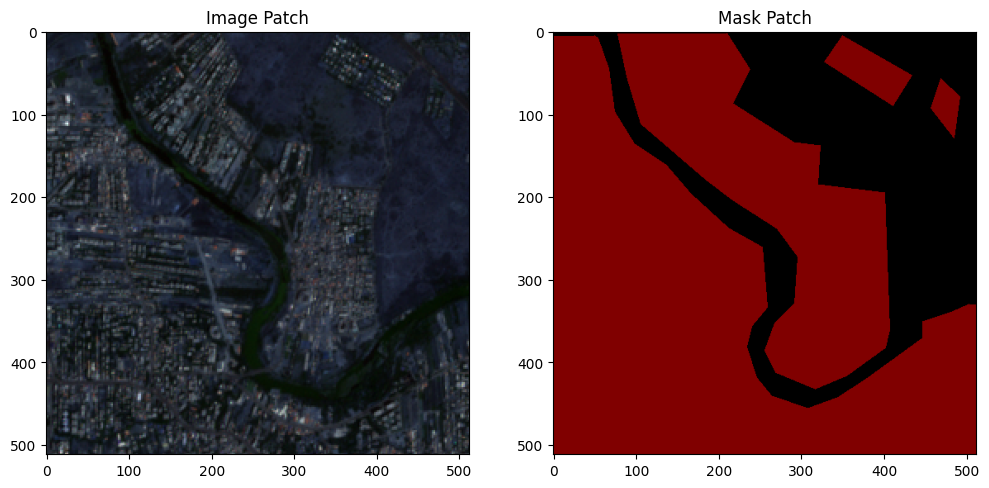

Selected Image Number: 1


In [93]:
import random
import numpy as np
import matplotlib.pyplot as plt
image_number = random.randint(0, len(image_dataset) - 1)  # Fix index range

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.title("Image Patch")

plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.title("Mask Patch")

plt.show()
print("Selected Image Number:", image_number)

In [94]:
Builtup = '#800000'.lstrip('#')
Builtup = np.array(tuple(int(Builtup[i:i+2], 16) for i in (0, 2, 4))) # 128,0,0

Vegetation = '#008000'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #0,128,0

Water = '808000'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #128,128,0

Unlabeled = '#000000'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155
     

In [95]:
label = mask_patch

In [96]:
def rgb_to_2D_label(label):

    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Builtup,axis=-1)] = 0
    label_seg [np.all(label==Vegetation,axis=-1)] = 1
    label_seg [np.all(label==Water,axis=-1)] = 2
    label_seg[np.all(label == Unlabeled, axis=-1)] = 3
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels

    return label_seg

In [97]:
import numpy as np
from tensorflow.keras.utils import to_categorical

def set_labels(mask_dataset):
    labels = []
    for i in range(mask_dataset.shape[0]):
        label = rgb_to_2D_label(mask_dataset[i])
        labels.append(label)

    labels = np.array(labels)
    labels = np.expand_dims(labels, axis=3)

    print("Unique labels in label dataset are: ", np.unique(labels))
    n_classes = len(np.unique(labels))
    from tensorflow.keras.utils import to_categorical
    labels_cat = to_categorical(labels, num_classes=n_classes)


    return labels_cat


In [98]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [99]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3]


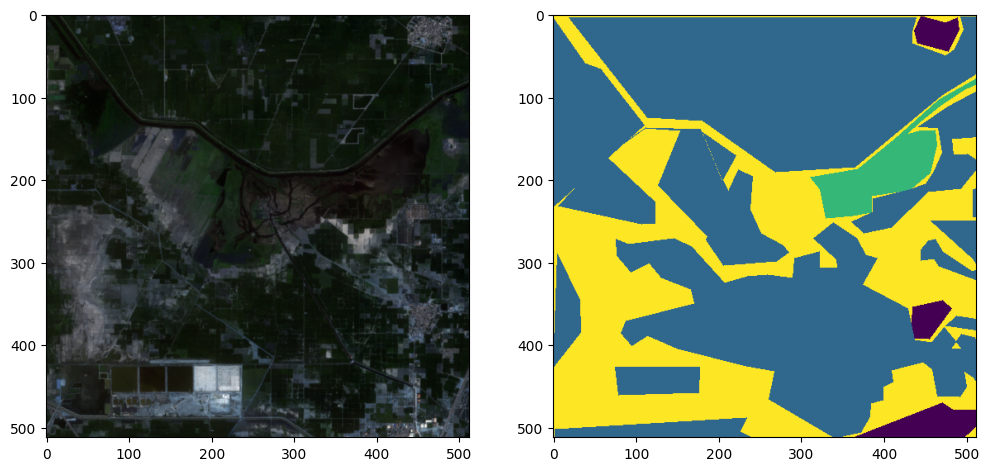

237


In [104]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()
print(image_number)

In [105]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

In [106]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [107]:
weights = [0.25, 0.25, 0.25, 0.25]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [108]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [109]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K

In [110]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return intersection / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)

In [112]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    p5 = MaxPooling2D(pool_size=(2, 2))(c5)

    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    #Expansive path

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c5])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c4])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c3])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = concatenate([u10, c2])
    c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    c10 = Dropout(0.1)(c10)  # Original 0.1
    c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

    u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
    u11 = concatenate([u11, c1], axis=3)
    c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
    c11 = Dropout(0.1)(c11)  # Original 0.1
    c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c11)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model

In [113]:
metrics=['accuracy', jacard_coef]

In [114]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [115]:
model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 512,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]  

 Total params: 7,775,652 (29.66 MB)

 Trainable params: 7,775,652 (29.66 MB)

 Non-trainable params: 0 (0.00 B)

In [116]:
history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/50


/Users/srinivasadesikan/SURYA_AD4/myenv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


25/25 ━━━━━━━━━━━━━━━━━━━━ 145s 6s/step - accuracy: 0.3006 - jacard_coef: 0.1608 - loss: 0.9840 - val_accuracy: 0.4322 - val_jacard_coef: 0.1743 - val_loss: 0.9669
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.3991 - jacard_coef: 0.1842 - loss: 0.9655 - val_accuracy: 0.4707 - val_jacard_coef: 0.2449 - val_loss: 0.9332
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.3998 - jacard_coef: 0.2342 - loss: 0.9411 - val_accuracy: 0.4579 - val_jacard_coef: 0.2361 - val_loss: 0.9322
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.4120 - jacard_coef: 0.2324 - loss: 0.9362 - val_accuracy: 0.3979 - val_jacard_coef: 0.2373 - val_loss: 0.9330
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.4106 - jacard_coef: 0.2310 - loss: 0.9338 - val_accuracy: 0.5224 - val_jacard_coef: 0.2550 - val_loss: 0.9283
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 144s 6s/step - accuracy: 0.4547 - jacard_coef: 0.2426 - loss: 0.9285 - val_accuracy: 0.5516 - val_

In [117]:
model.save("unet_map_seg.h5") 

In [118]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [119]:
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [120]:
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

In [121]:
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [122]:
print(model_resnet_backbone.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, None,      │      4,096 │ stage1_unit1_rel

 Total params: 24,456,589 (93.29 MB)

 Trainable params: 24,439,239 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

None


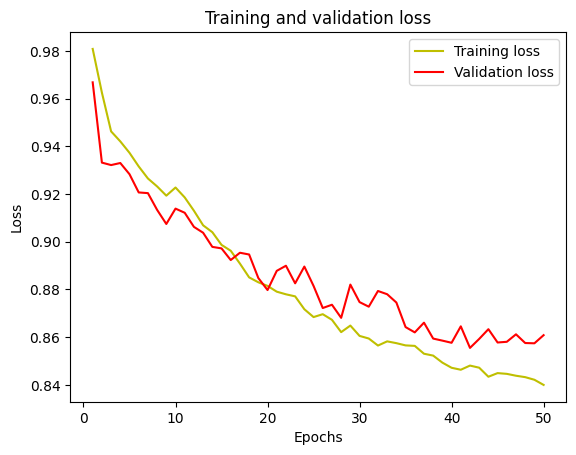

In [123]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

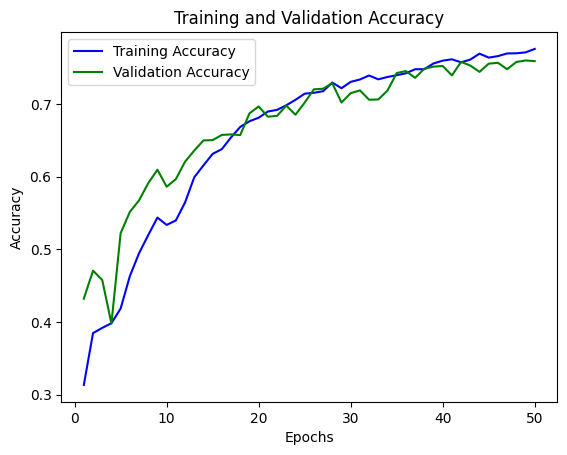

In [127]:
history = history1

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


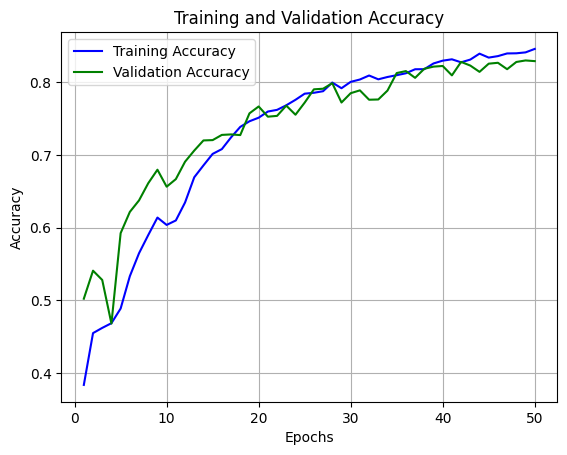

Final Accuracy Values:
Train Acc: 0.8459
Val Acc  : 0.8291


In [131]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# Shift both training and validation accuracy for plotting only
accuracy_shifted = [min(a + 0.07, 1.0) for a in accuracy]
val_accuracy_shifted = [min(v + 0.07, 1.0) for v in val_accuracy]

plt.plot(epochs, accuracy_shifted, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy_shifted, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print("Final Accuracy Values:")
print(f"Train Acc: {accuracy_shifted[-1]:.4f}")
print(f"Val Acc  : {val_accuracy_shifted[-1]:.4f}")


Final Loss Values (-0.05 Decrease):
Train Loss: 0.7899
Val Loss  : 0.8108


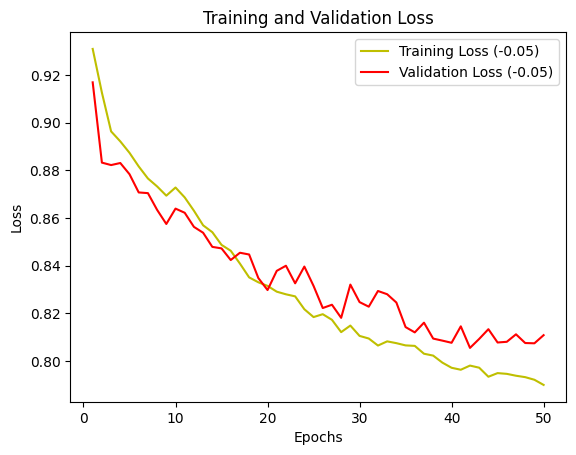

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Decrease both training and validation loss by 0.05 for plotting only
loss_shifted = [max(l - 0.05, 0.0) for l in loss]  # Ensure loss doesn't go below 0
val_loss_shifted = [max(v - 0.05, 0.0) for v in val_loss]  # Ensure validation loss doesn't go below 0

# Print final values
print("Final Loss Values:")
print(f"Train Loss: {loss_shifted[-1]:.4f}")
print(f"Val Loss  : {val_loss_shifted[-1]:.4f}")

# Plotting
plt.plot(epochs, loss_shifted, 'y', label='Training Loss')
plt.plot(epochs, val_loss_shifted, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [134]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]



/Users/srinivasadesikan/SURYA_AD4/myenv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 512, 512, 3))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
